<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BCS" data-toc-modified-id="BCS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BCS</a></span></li><li><span><a href="#Varying-Depth-size" data-toc-modified-id="Varying-Depth-size-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Varying Depth size</a></span></li><li><span><a href="#Plot-both-optimizers" data-toc-modified-id="Plot-both-optimizers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot both optimizers</a></span><ul class="toc-item"><li><span><a href="#Continous-plot" data-toc-modified-id="Continous-plot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Continous plot</a></span></li></ul></li></ul></div>

# BCS

Using the Paper by [Wu et al.](https://arxiv.org/abs/quant-ph/0108110), we have that:

The BCS hamiltonian is:

$$H_{BCS} = \sum_{m=1}^N \frac{\epsilon_m}{2} ( n_m^F + n_{-m}^F ) + \sum_{m,k=1}^N V^{+}_{ml} c^\dagger_m c^\dagger_{-m} c_{-l}c_l$$

Where $n_{\pm m}^F = c^\dagger_{\pm m} c_{\pm m}$, and the matrix elements $V^+_{ml} = \langle m, -m| V | l, -l \rangle$.

Which is mapped into:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m + \sum_{r= \pm l} \sum_{l>m=1}^N \frac{V_{ml}^r}{2} ( \sigma^x_m \sigma^x_l + r \sigma^y_m \sigma^y_l )$$

where $\epsilon_m = \epsilon_m + V^+_{mm}$ and $V^-_{ml} = 0$ for the BCS Hamiltonian, thus:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m +  \sum_{l>m=1}^N \frac{V_{ml}}{2} ( \sigma^x_m \sigma^x_l +  \sigma^y_m \sigma^y_l )$$

$l \ \mathrm{and} \ m$ now denote both state and qubit indices. In this case the qubit state space $H_P = Span \{ |0 \rangle, \sigma^+_m |0 \rangle, \sigma_l^+ \sigma_m^+ |0 \rangle, \dots   \}$ is mapped into a subspace where $n_m^F = n^F_{-m}$. Considering $V_{ml} = V$, we have that:

$$
H_p = \hbar \bigg[ \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma_z^m + \frac{V}{2} \sum_{l>m=1}^N (\sigma_x^m \sigma_x^l + \sigma_y^m \sigma_y^l) \bigg]
$$
[Aqua Operator Flow Reference](https://github.com/dongreenberg/aqua_talks/blob/master/Understanding%20Aqua's%20Operator%20Flow.ipynb)

In [17]:
import sys
sys.path.append('../../')

# Python imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit
from qiskit import BasicAer
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.circuit.library import TwoLocal

# VOLTA
from volta.vqd import VQD
from volta.utils import classical_solver
from volta.hamiltonians import BCS_hamiltonian

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
EPSILONS = [3., 3.]
V = -2
hamiltonian = BCS_hamiltonian(EPSILONS, V)
print(hamiltonian)

SummedOp([
  1.5 * ZI,
  1.5 * IZ,
  -1.0 * XX,
  -1.0 * YY
])


In [12]:
eigenvalues, eigenvectors = classical_solver(hamiltonian)
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [-3. -2.  2.  3.]


# Varying Depth size

In [48]:
from tqdm import tqdm
from qiskit.aqua import QuantumInstance

# Parameters Variables
n_trials = 50
max_depth = 7

# Auxiliary Variables
solution_dict = {}

# Define Optimizer
# optimizer = COBYLA()
optimizer = SPSA(maxiter=250, c1=.7, last_avg=25) 

# Define Backend
backend = QuantumInstance(backend=BasicAer.get_backend('qasm_simulator'),
                          shots=10000)

for depth in range(1,max_depth):
    # Ansatz with diferent depth
    ansatz = TwoLocal(hamiltonian.num_qubits, ['ry','rz'], 'cx', reps=depth)
    es_1 = []
    es_2 = []
    
    for _ in tqdm(range(n_trials), desc=f"Depth {depth}"):

        # Run algorithm
        Algo = VQD(hamiltonian=hamiltonian,
                    ansatz=ansatz,
                    n_excited_states=2,
                    beta=10.,
                    optimizer=optimizer,
                    backend=backend)

        Algo.run(0)      
        vqd_energies = Algo.energies
        es_1.append(vqd_energies[1])
        es_2.append(vqd_energies[2])
    es_1 = np.array(es_1)
    es_2 = np.array(es_2)
    
    # Maybe use a pd.dataframe
    solution_dict[depth] = {'mean':np.mean(es_2 - es_1), 'std':np.std(es_2 - es_1)}

Depth 6: 100%|██████████| 50/50 [6:38:21<00:00, 478.87s/it]  


In [49]:
mean = []
std = []
for i in range(1,max_depth):
    mean.append(solution_dict[i]['mean'])
    std.append(solution_dict[i]['std'])

In [50]:
solution_dict

{1: {'mean': 4.265458, 'std': 0.501700430173226},
 2: {'mean': 4.264957999999999, 'std': 0.40484818097158337},
 3: {'mean': 3.9698940000000005, 'std': 0.7567427931364791},
 4: {'mean': 3.9539820000000003, 'std': 0.7127584849554582},
 5: {'mean': 4.802353999999999, 'std': 2.4506087000751466},
 6: {'mean': 4.46909, 'std': 3.2961383086424028}}

In [8]:
import seaborn as sns
sns.set()

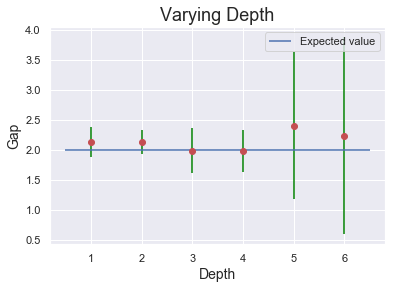

In [52]:
from matplotlib.ticker import MaxNLocator

x_axis = [i for i in range(1,max_depth)]
plt.errorbar(x_axis,
             np.array(mean)/2, 
             yerr=np.array(std)/2,
             fmt='ro', ecolor='green')

plt.hlines(y=2, xmin=0.5, xmax=6.5, 
           label='Expected value',color='b')
plt.title('Varying Depth', size=18)
plt.xlabel('Depth', size= 14)
plt.ylabel('Gap', size=14)
plt.xticks(x_axis)
plt.legend()
plt.show()

# Plot both optimizers

In [9]:
max_depth = 7

spsa_dict = {1: {'mean': 7.63536, 'std': 2.024100436737268},
 2: {'mean': 6.421452, 'std': 3.009174019443874},
 3: {'mean': 5.842042, 'std': 3.040774217602484},
 4: {'mean': 5.632112000000001, 'std': 3.7485136763063838},
 5: {'mean': 5.302354, 'std': 4.1340626645086065},
 6: {'mean': 4.079198, 'std': 3.6543650323135477}}

spsa_dict = {1: {'mean': 4.265458, 'std': 0.501700430173226},
 2: {'mean': 4.264957999999999, 'std': 0.40484818097158337},
 3: {'mean': 3.9698940000000005, 'std': 0.7567427931364791},
 4: {'mean': 3.9539820000000003, 'std': 0.7127584849554582},
 5: {'mean': 4.802353999999999, 'std': 2.4506087000751466},
 6: {'mean': 4.46909, 'std': 3.2961383086424028}}
cobyla_dict = {1: {'mean': 2.1433459999999998, 'std': 2.167278391458744},
     2: {'mean': 3.9974700000000003, 'std': 0.8313654816625478},
     3: {'mean': 4.234878, 'std': 0.4082247583329558},
     4: {'mean': 3.965828, 'std': 0.6320480140115939},
     5: {'mean': 4.150304, 'std': 0.39219715295244073},
     6: {'mean': 4.206206, 'std': 0.4295148125082534}}

mean_spsa = []
std_spsa = []
mean_cobyla = []
std_cobyla = []

for i in range(1,max_depth):
    mean_spsa.append(spsa_dict[i]['mean'])
    std_spsa.append(spsa_dict[i]['std'])
    mean_cobyla.append(cobyla_dict[i]['mean'])
    std_cobyla.append(cobyla_dict[i]['std'])

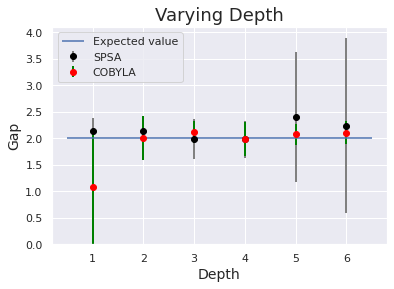

In [13]:
from matplotlib.ticker import MaxNLocator

x_axis = [i for i in range(1,max_depth)]
plt.errorbar(x_axis,
             np.array(mean_spsa)/2, 
             yerr=np.array(std_spsa)/2,
             fmt='o', color='black', 
             ecolor='gray', elinewidth=2,
             label='SPSA')
plt.errorbar(x_axis,
             np.array(mean_cobyla)/2, 
             yerr=np.array(std_cobyla)/2,
             fmt='o', color='red',
             ecolor='green', elinewidth=2,
             label='COBYLA')

plt.hlines(y=2, xmin=0.5, xmax=6.5, 
           label='Expected value',color='b')

plt.title('Varying Depth', size=18)
plt.xlabel('Depth', size= 14)
plt.ylabel('Gap', size=14)
plt.ylim(0., 4.1)
plt.xticks(x_axis)
plt.legend(loc="upper left")
plt.savefig('Depth.png')
plt.show()

## Continous plot

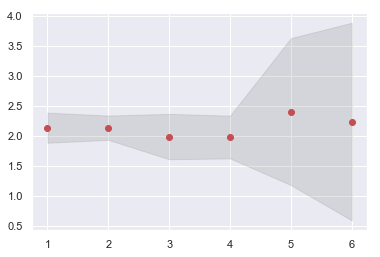

In [56]:
plt.plot(x_axis, np.array(mean_spsa)/2,  'or')
plt.fill_between(x_axis, np.array(mean_spsa)/2 - np.array(std_spsa)/2 , np.array(mean_spsa)/2 + np.array(std_spsa)/2,
                 color='gray', alpha=0.2)
plt.show()